# Análise de dados de brassagem de produção artesanal de cerveja

Aqui, a ideia é apresentar de forma simples como pode ser feita a análise de dados na indústria através de dados coledados em brassagem de produção artesanal de cerveja.

Objetivo para a análise:
* coletar dados
* visualizar dados
* analisar dados
* validar hipoteses
* criar indicador para a qualidade da brassagem


Objetivo para o estudante:
* apresentar um passo a passo de como pode ser feita a análise de dados na indústria
* apresentar as principais ferramentas utilizadas na análise


<br/>
Esse arquivo faz parte do curso de análise de dados...

O arquivo foi apresentado no seguinte vídeo...

<br/>

Análise feita por Jônathan Dambros (CEO Latos)<br/>
Saiba mais sobre a Latos: [http://www.latos.ai](http://www.latos.ai)<br/>
Siga-nos no [LinkedIn](https://www.linkedin.com/company/latosai/) 


In [39]:
# importação de bibliotecas que utilizaresmos

# bibliotecas básicas 
import os
import pickle
from pathlib import Path
import datetime

# biblioteca básica para computação numérica
import numpy as np 
import pandas as pd

# bibliotécas gráficas
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# biblioteca de aprendizado de máquina
from sklearn.linear_model import LinearRegression

# biblioteca para consulta de dados no EPM da Elipse
import epmwebapi as epm

In [40]:
# identificar o caminho presente projeto o da pasta de dados
cwd = os.getcwd()
project_folder = Path(cwd).parents[0]
dataset_folder = project_folder / 'data'

# tamanho das figuras que plotaremos
figsize = (10, 5)

## Consulta de dados via epmwebapi

In [48]:
import getpass

user = input('EPM user:')
password = getpass.getpass("EPM password:")
epm_auth = 'http://epmtr.elipse.com.br:44333'
epm_web  = 'http://epmtr.elipse.com.br:44332'

# conecção com o EPM Server para coletarmos os dados
connection = epm.EpmConnection(epm_auth, epm_web, user, password)

EPM user:jonathan
EPM password:········


In [50]:
### OBS: Aqui consideramos que já fizemos uma análise no EPMStudio e já verificamos as variáveis que iremos 
# trabalhar e o período de tempo.

# seleção das tags que iremos utilizadar
tags = ['node01_stage', 'node01_temp2_ds18', 'node01_temp_sp']

# novo nome para as tags. Auxilia na análise 
tags_new = ['stage', 'temp', 'sp']

# período de coleta dos dados (em UTC)
ini_date = datetime.datetime(2020, 5, 17)
end_date = datetime.datetime(2020, 5, 18)

# coleta dos dados
bv = connection.getDataObjects(tags)
queryPeriod = epm.QueryPeriod(ini_date, end_date)

### OBS: Não vamos transformar o timestamp de UTC para horário de Brasília, já que isso não vai influenciar na análise
# Durante a análise, é bom focar naquilo que é necessário. Fazer o que não é necessário consome tempo/dinheiro e 
# pode deixar a análise extensa e difícil de entender/interpretar.

Internal Server Error


Exception: Read service call http error '500'. Reason: Internal Server Error

In [ ]:
# transformação dos dados para pandas

data = {}
for t, t_new in zip(tags, tags_new):
    # consulta os dados
    d = bv[t].historyReadRaw(queryPeriod)
    
    # transforma para DataFrame do Pandas
    new_Quality = d[:]['Quality'].byteswap().newbyteorder()
    new_Timestamp = d[:]['Timestamp']
    new_Value = d[:]['Value'].byteswap().newbyteorder()

    d_dict = {'value':new_Value, 'timestamp':new_Timestamp, 'quality':new_Quality}

    data[t_new] = pd.DataFrame(d_dict) 


# verificando os dados
data['temp'].head()

In [ ]:
# savando os dados
pickle.dump(data, open(f'{dataset_folder}\\dados.p', "wb")) 

### OBS: Nesse ponto, é interessante salvar os dados para sempre retomar a análise daqui. 
# Isso evita que precisamos fazer novas consultas ao servidor e retransformar os dados para DataFrame. 
# Esses operações podem ser muito lentas para grande bancos de dados.
# Também evita que consumomos muito I/O no caso da máquina na núvem.

## Carregando dados Salvos

In [81]:
data = pickle.load(open(f'{dataset_folder}\\dados.p', 'rb'))

## Visualizando os dados

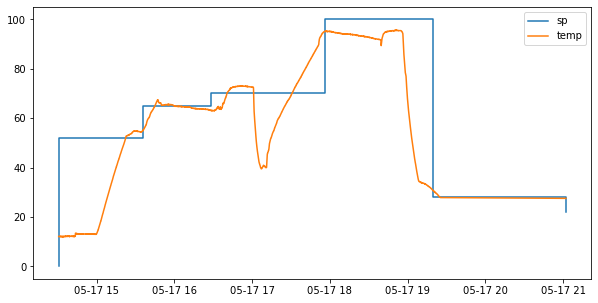

In [83]:
plt.figure(figsize=figsize)
plt.step(data['sp']['timestamp'], data['sp']['value'], label='sp', where='post')
plt.plot(data['temp']['timestamp'], data['temp']['value'], label='temp')
plt.legend()
plt.show()

In [84]:
fig = go.Figure([go.Scatter(x=data['sp']['timestamp'], y=data['sp']['value'], name='sp', line_shape='hv'),
                go.Scatter(x=data['temp']['timestamp'], y=data['temp']['value'], name='temp')])

fig.show()

### OBS: a biblioteca pyplot, utilizada para plotar esse gráfico, é excelente para se obter os primeiros insights dos dados.
# Aqui já podemos identificar os tipos de pré-processamentos e limpeza que precisaremos executar.
# Nesse caso, os dados são de boa qualidade, ou seja, não temos ruído, tendências, valores espúrios, valores nans, por exemplo.

### Obs: outro biblioteca interessante para a visualização de dados é a seaborn (principalmente relacionadas 
# a visualização de propriedades estatítsicas)

In [86]:
# Identificação de pontos relevantes para próximas análises (identificado por anotações do operador no EPM)
# etapa de mosturação
inic_aquec = np.datetime64('2020-05-17T15')
fim_aquec = np.datetime64('2020-05-17T15:22')
sac1_aq = np.datetime64('2020-05-17T15:34')
sac1_ret = np.datetime64('2020-05-17T15:46:30')
sac2_aq = np.datetime64('2020-05-17T16:29:00')
sac2_ret = np.datetime64('2020-05-17T16:40:00')
fim_sac2_ret = np.datetime64('2020-05-17T16:58')

# etapa fervura
inic_aquec_ferv = np.datetime64('2020-05-17T17:07')
fim_aquec_ferv = np.datetime64('2020-05-17T17:53')

#etapa de resfriamento (sem recirculação)
inic_resf = np.datetime64('2020-05-17T18:53')
fim_resf = np.datetime64('2020-05-17T19:07')

## Analisando os dados

In [87]:
data['temp'].head(10)

,value,timestamp,quality
0,12.13,2020-05-17 14:30:48+00:00,0
1,12.13,2020-05-17 14:30:49+00:00,0
2,12.13,2020-05-17 14:30:50+00:00,0
3,12.13,2020-05-17 14:30:53+00:00,0
4,12.13,2020-05-17 14:30:56+00:00,0
5,12.13,2020-05-17 14:30:58+00:00,0
6,12.13,2020-05-17 14:31:01+00:00,0
7,12.13,2020-05-17 14:31:04+00:00,0
8,12.13,2020-05-17 14:31:06+00:00,0
9,12.13,2020-05-17 14:31:09+00:00,0


In [88]:
temp_data = data['temp']
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6421 entries, 0 to 6420
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   value      6421 non-null   float32            
 1   timestamp  6421 non-null   datetime64[ns, UTC]
 2   quality    6421 non-null   int64              
dtypes: datetime64[ns, UTC](1), float32(1), int64(1)
memory usage: 125.5 KB


In [89]:
temp_data.describe()

,value,quality
count,6421.000000,6421.0
mean,61.416985,0.0
std,25.635670,0.0
min,12.000000,0.0
25%,44.130001,0.0
50%,64.440002,0.0
75%,82.940002,0.0
max,95.620003,0.0


In [90]:
temp_data.nunique()

value        1227
timestamp    6421
quality         1
dtype: int64

In [91]:
temp_data['quality'].value_counts()

### OBS: Essas análises não fazem muito sentido, já que temos três fases na mosturação. 
# O ideal seria dividirmos as três fases e trabalharmos separadamente.

0    6421
Name: quality, dtype: int64

### Outras possíveis análises

Para esse exemplo, estamos analisando apenas uma variável. Normalmente temos centenas em um período de tempo de meses. Para esses casos, podemos incluir as seguintes análises:
* testar correlações entre variáveis - pode ser necessário para verificar a dependência de variáveis. Outra aplicação é reduzir o número de variáveis para os próximos passos da análise, já que se temos variáveis fortemente correlacionadas, escolher uma é o suficiente.
* analisar no domínio da frequência - verificar padrões periódicos na variável, como mudança diária de temperatura, padrões de vibração (utilizado para detecção de falhas em motores, por exemplo), controle mal ajustado.
* analisar distribuições - comparar distribuição (histograma, box-plot, violin plot, ...) pode ser útil para a distinção de comportamento normal e anormal de equipamento, por exemplo.
* ...


## Validar hipoteses

Na análise dos dados, se trabalha muito com validação de hipôteses.
Pensamos que algo pode ser verdadeiro. Provamos que estamos certos ou errados a partir dos dados.

### Hipotese: o aumento de temperatura na fase de aquecimento é linear

Como testar? Selecionar dados no período de aquecimento e fazer ajuste linear.

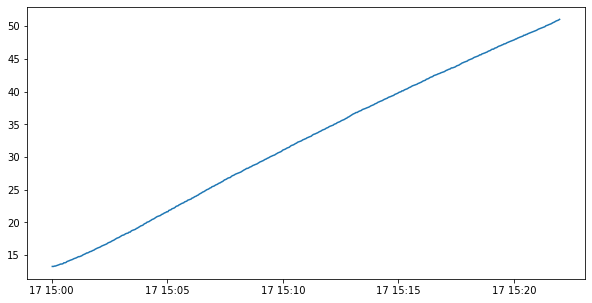

In [92]:
# seleção dos dados durante o aquecimento
ind = (temp_data['timestamp'].values > inic_aquec) & (temp_data['timestamp'].values < fim_aquec)
temp_data_aquec = temp_data[ind]

plt.figure(figsize=figsize)
plt.plot(temp_data_aquec['timestamp'], temp_data_aquec['value'])
plt.show()

### OBS: Para plots rápidos, é melhor utilizar o matpltlib por dois motivos: mais rápido/fácil de escrever o 
# código e mais rápido para plotar os dados.
### OBS: É sempre bom verificar os dados após alguma operação. Se alguma coisa está errada, é mais fácil de 
# se corrigir agora, que mais tarde.

score: 0.9990
T(C°) = 13.05 + 1.77 * tempo (min)


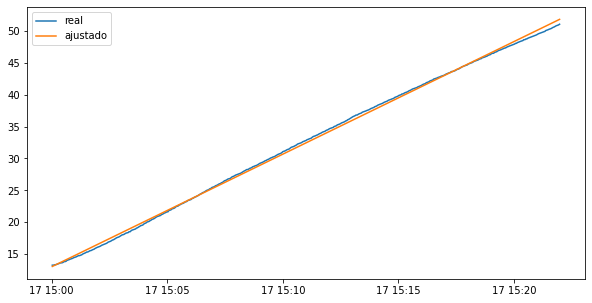

In [93]:
X = temp_data_aquec['timestamp'].values
y = temp_data_aquec['value'].values


# regressão não aceita valores do tipo datetime, então precisamos transformar para numérico
X = X - X[0] # diferença para o primeiro timestamp
X = X.astype('float64') / (1e9 * 60) # conversão para minutos do tipo float
X = [[x] for x in X] # transformação para matrix 2D, como exigido pelo scikitlearn


reg = LinearRegression()
reg.fit(X, y) # ajuste

print(f'score: {reg.score(X, y):.4f}')
print(f'T(C°) = {reg.intercept_:.2f} + {reg.coef_[0]:.2f} * tempo (min)')

y_pred = reg.predict(X)

# gráfico
plt.figure(figsize=figsize)
plt.plot(temp_data_aquec['timestamp'], y, label='real')
plt.plot(temp_data_aquec['timestamp'], y_pred, label='ajustado')
plt.legend()
plt.show()

Como observado, o ajuste linear foi quase perfeito. Ou seja, o período de aquecimento pode ser representado por curva linear. Essa informação pode ser útil para atender alguma demanda do cliente, como:
* estimar o tempo para o final do aquecimento (predição)
* detectar diminuição de desempenho no aquecedor - poderia ser pela diminuição da inclinação da curva (manutenção preditiva)
* detectar falhas no sensor - variância muito grande em torno da linha (detecção de falhas)
* ...

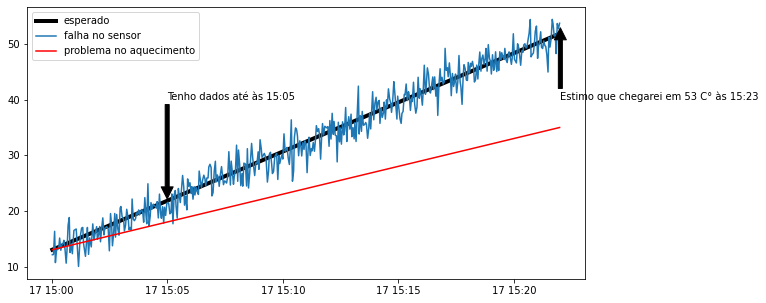

In [94]:
# apenas para criar a figura, depois removerei
y_pred_noise = y_pred + 2 * np.random.randn(len(y_pred))

reg.coef_[0] = 1
y_pred_fault = reg.predict(X)

plt.figure(figsize=figsize)
plt.plot(temp_data_aquec['timestamp'], y_pred, label='esperado', lw=4, color='k')
plt.plot(temp_data_aquec['timestamp'], y_pred_noise, label='falha no sensor')
plt.plot(temp_data_aquec['timestamp'], y_pred_fault, label='problema no aquecimento', color='r')


t1 = np.datetime64('2020-05-17T15:05')

plt.annotate('Tenho dados até às 15:05', xy=(t1, 22), xytext=(t1, 40),
            arrowprops=dict(facecolor='black', shrink=0.01),
            )

plt.annotate('Estimo que chegarei em 53 C° às 15:23', xy=(fim_aquec, 53), xytext=(fim_aquec, 40),
            arrowprops=dict(facecolor='black', shrink=0.01),
            )

plt.legend()
plt.show()

### Para as demais curvas de aquecimento

O procedimento é o mesmo, então podemos criar uma função.

OBS: Essa função poderia fazer parte de um pacote vendível, que poderia rodar no EPM. 

In [95]:
def curva_aquecimento(temp_data, inic_aquec, fim_aquec):

    # seleção dos dados durante o aquecimento
    ind = (temp_data['timestamp'].values > inic_aquec) & (temp_data['timestamp'].values < fim_aquec)
    temp_data_aquec = temp_data[ind]

    X = temp_data_aquec['timestamp'].values
    y = temp_data_aquec['value'].values

    # regressão não aceita valores do tipo datetime, então precisamos transformar para numérico
    X = X - X[0] # diferença para o primeiro timestamp
    X = X.astype('float64') / (1e9 * 60) # conversão para minutos do tipo float
    X = [[x] for x in X] # transformação para matrix 2D, como exigido pelo scikitlearn

    reg = LinearRegression()
    reg.fit(X, y) # ajuste

    print(f'score: {reg.score(X, y):.4f}')
    print(f'T(C°) = {reg.intercept_:.2f} + {reg.coef_[0]:.2f} * tempo (min)')

    y_pred = reg.predict(X)  
       
    plt.figure(figsize=figsize)
    plt.plot(temp_data_aquec['timestamp'], y, label='real')
    plt.plot(temp_data_aquec['timestamp'], y_pred, label='ajustado')
    plt.legend()
    plt.show()

score: 0.9928
T(C°) = 53.39 + 1.07 * tempo (min)


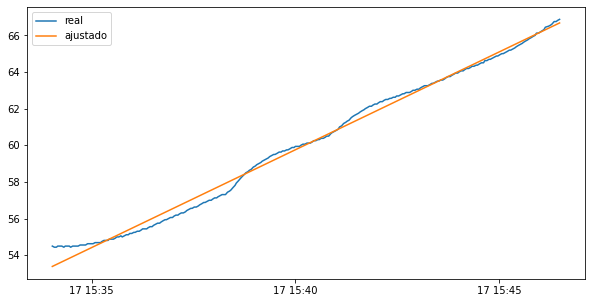

In [96]:
# para o aquecimento na etapa de sacarificação 1
curva_aquecimento(temp_data, sac1_aq, sac1_ret)

score: 0.7584
T(C°) = 62.21 + 0.43 * tempo (min)


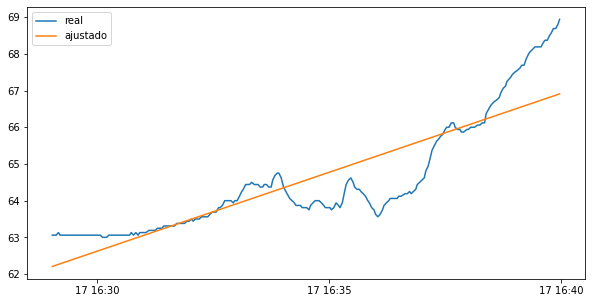

In [97]:
# para o aquecimento na etapa de sacarificação 2
curva_aquecimento(temp_data, sac2_aq, sac2_ret)

score: 0.9807
T(C°) = 42.51 + 1.11 * tempo (min)


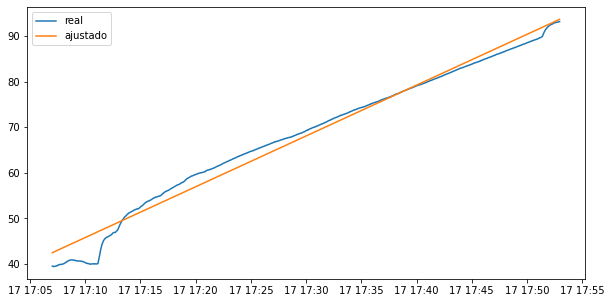

In [98]:
# para o aquecimento até fervura
curva_aquecimento(temp_data, inic_aquec_ferv, fim_aquec_ferv)

score: 0.9791
T(C°) = 102.88 + -4.86 * tempo (min)


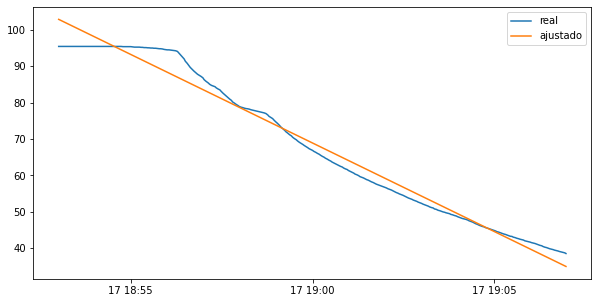

In [100]:
# para resfriamento
curva_aquecimento(temp_data, inic_resf, fim_resf)

## Criando indicadores

Frequentemente precisamos criar indicadores para "indicar":
* condições/saúde de um equipamento
* eficiência energética
* qualidade de produto/matéria-prima
* desempenho de processo
* ...

Aqui vamos avaliar o trabalho do nosso operador. O quão próximo a brassagem prática foi em comparação ao planejado?

In [101]:
# Valores tirados da receita
# temperaturas teóricas para cada fase (C°)
T_aquec = 52
T_sac1 = 64
T_sac2 = 70

# tempo teórico para os aquecimentos (min)
tempo_aquec_sac1 = 13
tempo_aquec_sac2 = 10

# tempo teórico de repouso (min)
tempo_rep_aquec = 10
tempo_rep_sac1 = 40
tempo_rep_sac2 = 20

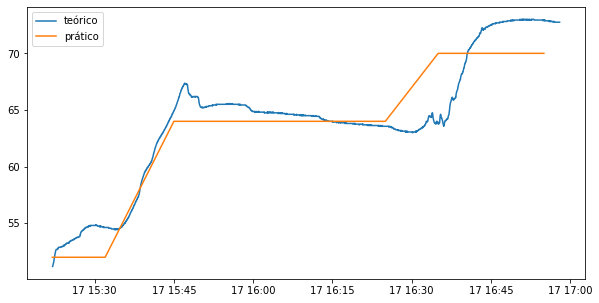

In [102]:
# Gráfico teórico vc. prático

# juntando todas as informações teóricas
T_teorico = [T_aquec, T_aquec, T_sac1, T_sac1, T_sac2, T_sac2]
tempo_teorico = np.cumsum([0, tempo_rep_aquec, tempo_aquec_sac1, tempo_rep_sac1, tempo_aquec_sac2, tempo_rep_sac2]) + fim_aquec

# separando apenas período de mosturação
ind = (temp_data['timestamp'].values > fim_aquec) & (temp_data['timestamp'].values < fim_sac2_ret)
T_pratico = data['temp']['value'][ind]
tempo_pratico = data['temp']['timestamp'][ind] 

# gráfico
plt.figure(figsize=figsize)
plt.plot(tempo_pratico, T_pratico, label='teórico')
plt.plot(tempo_teorico, T_teorico, label='prático')
plt.legend()
plt.show()

In [69]:
# indicadores que calcularesmos: erro absoluto médio e erro quadrado médio

# interpolação de dados teóricos para o mesmo timestamp
def time_to_float(X, t_base):
    X = X.astype('datetime64[ns]')
    X = X - t_base # diferença para o primeiro timestamp
    X = X.astype('float64') / (1e9 * 60) # conversão para minutos do tipo float
    return X

t0 = tempo_pratico.values[0]
x = time_to_float(tempo_pratico.values, t0)
xp = time_to_float(tempo_teorico, t0)
T_teorico_interp = np.interp(x, xp, T_teorico)

# essas funções existem na biblioteca numpy, mas preferi escrever para mostrar o cálculo do erro
MAE = sum(abs(T_teorico_interp - T_pratico)) / len(T_pratico)
MSE = sum((T_teorico_interp - T_pratico) ** 2) / len(T_pratico)

print(f'O operador errou a temperatura em média {MAE:.2f} graus')
print(f'O erro quadrado médio da temperatura foi de {MSE:.2f}')

O operador errou a temperatura em média 1.72 graus
O erro quadrado médio da temperatura foi de 4.97


### Para onde isso pode evoluir

Esse indicador não é o melhor. Pensa que o operador atrasou 3 minutos em uma das etapas, pode ser que ele acelere o aquecimento ou reduza o tempo da próxima para compensar o tempo perdido e melhorar o indicador. Isso pode destruir a cerveja! Para melhorar, o ideal seria calcular um indicador para cada etapa.

Outros possíveis indicadores para o processo podem ser:
* consumo de energia por brassagem
* relação matéria prima/produto - quanto eu consegui produzir com a mesma quantidade de matéria-prima
* relação gasto/faturamento
* número de brassagens por período


Aqui já temos várias coisas que podemos adicionar ao nosso pacote. Após implementado, seguimos para os testes. Se tudo estiver ok, podemos começar as vendas!